In [41]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated2.csv')

data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)

data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
data['pct_caucasian'] = data['ETH1_EUR'] / data['POPULATION']
data['pct_africanamerican'] = data['ETH1_AA'] / data['POPULATION']
data['pct_other'] = data['ETH1_OTHERS'] / data['POPULATION']

data['Biden Percentage'] = data['Biden Percentage'] / 100
data['Trump Percentage'] = data['Trump Percentage'] / 100
data['Others Percentage'] = 1 - data['Biden Percentage'] - data['Trump Percentage']

data = data.dropna()
rows_with_negative_eth_other = data[data['ETH1_OTHERS'] < 0]
data = data.drop(rows_with_negative_eth_other.index)
data.head()
print(data)

     OBJECTID  DISTRICT  POPULATION   RDED  TOTAL_REG  ETH1_EUR  ETH1_AA  \
42         55         4        1202  04-01       1614      1237       23   
52         65         4        1073  04-11       1416      1102      110   
101       114         8         973  08-07       1272       865      179   
152       165        12         174  12-08        262       207        8   

     Biden Percentage  Trump Percentage  ETH1_OTHERS  pct_caucasian  \
42             0.7407            0.2452          -58       1.029118   
52             0.6382            0.3476         -139       1.027027   
101            0.4559            0.5243          -71       0.889003   
152            0.5904            0.3976          -41       1.189655   

     pct_africanamerican  pct_other  Others Percentage  
42              0.019135  -0.048253             0.0141  
52              0.102516  -0.129543             0.0142  
101             0.183967  -0.072970             0.0198  
152             0.045977  -0.235632

C:\Users\danda\AppData\Local\Temp\ipykernel_16304\1415710196.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_16304\1415710196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_16304\1415710196.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,OBJECTID,DISTRICT,POPULATION,RDED,TOTAL_REG,ETH1_EUR,ETH1_AA,Biden Percentage,Trump Percentage,ETH1_OTHERS,pct_caucasian,pct_africanamerican,pct_other,Others Percentage
0,1,1,1602,01-01,1254,211,936,0.9177,0.0646,455,0.131710,0.584270,0.284020,0.0177
1,2,1,1982,01-02,1579,155,1310,0.9469,0.0475,517,0.078204,0.660949,0.260848,0.0056
2,3,1,1692,01-03,1262,83,1094,0.9569,0.0406,515,0.049054,0.646572,0.304374,0.0025
3,4,1,2067,01-04,1619,249,1224,0.9342,0.0545,594,0.120464,0.592163,0.287373,0.0113
4,5,1,2063,01-05,1636,589,826,0.8611,0.1234,648,0.285507,0.400388,0.314106,0.0155


In [42]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_caucasian','pct_africanamerican', 'pct_other']]).T
votes_fractions = np.array(data[['Biden Percentage', 'Trump Percentage','Others Percentage']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

negative_values = group_fractions[group_fractions < 0]
print("Negative values:", negative_values)

candidate_names_rbyc = ['Biden', 'Trump', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["POPULATION"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)


Negative values: []
Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 424


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [63]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
#np.set_printoptions(threshold=np.inf)

demographic_group_counts = np.transpose(
            ei_rbyc.demographic_group_fractions * ei_rbyc.precinct_pops
        )
#print(demographic_group_counts)



print(sampled_voting_prefs[:,0,0])

[[[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.574102

array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

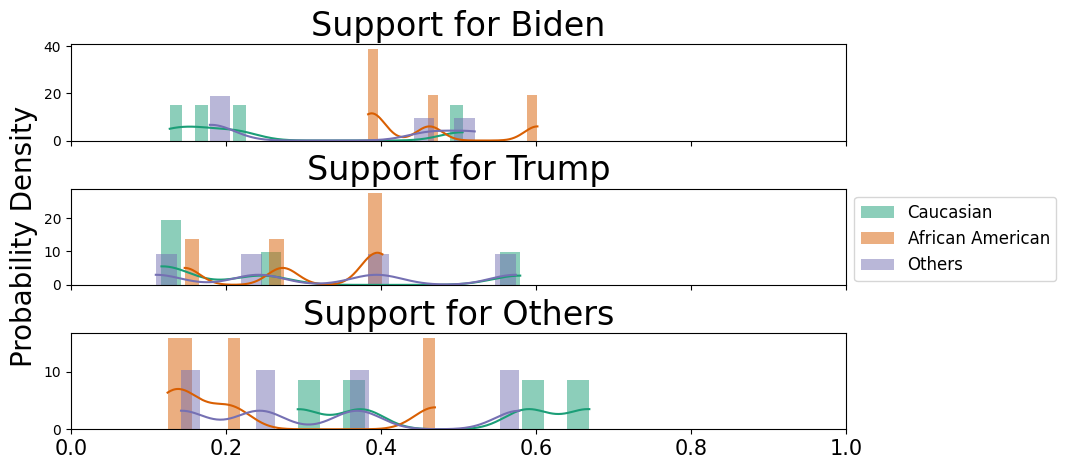

In [44]:
ei_rbyc.plot()

In [64]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist()  # Converting numpy array to Python list
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)
